# 第七次作业

[参考资料](https://blog.csdn.net/u010089444/article/details/80516345)

![Q-learing and sarsa](https://img-blog.csdn.net/20180530212805971?watermark/2/text/aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3UwMTAwODk0NDQ=/font/5a6L5L2T/fontsize/400/fill/I0JBQkFCMA==/dissolve/70)

&emsp;&emsp;当Sarsa 和 Q-Learning处在状态s时，均选择可带来最大回报的动作a，这样可到达状态s’。而在下一步，如果使用Q-Learning， 则会观察在s’上哪个动作会带来最大回报（不会真正执行该动作，仅用来更新Q表），在s’上做决定时, 再基于更新后的Q表选择动作。而 Sarsa 是实践派，在s’ 这一步估算的动作也是接下来要执行的动作，所以 Q(s, a) 的现实值也会稍稍改动，去掉maxQ，取而代之的是在s’ 上实实在在选取的a’ 的Q值，最后像Q-Learning一样求出现实和估计的差距并更新Q表里的Q(s, a)。


In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# 网格高度
WORLD_HEIGHT = 7

# 网格宽度
WORLD_WIDTH = 10

# 每一列风的强度
WIND = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]

# 可能执行的动作
ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3

# 探索率
EPSILON = 0.1

# Sarsa 步长
ALPHA = 0.5

# 每一步的奖励
REWARD = -1.0

# 起始点
START = [4, 2]

# 终点
GOAL = [3, 6]

# 动作集
ACTIONS = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]
ACTIONS_ARROW = ['↑', '↓', '←', '→']

In [3]:
# 状态采取一个动作后到达下一个状态的位置
def step(state, action):
    i, j = state
    if action == ACTION_UP:
        return [max(i - 1 - WIND[j], 0), j]
    elif action == ACTION_DOWN:
        return [max(min(i + 1 - WIND[j], WORLD_HEIGHT - 1), 0), j]
    elif action == ACTION_LEFT:
        return [max(i - WIND[j], 0), max(j - 1, 0)]
    elif action == ACTION_RIGHT:
        return [max(i - WIND[j], 0), min(j + 1, WORLD_WIDTH - 1)]
    else:
        assert False

In [4]:
# Sarsa算法
def episode_Sarsa(q_value):
    time = 0

    # 初始化state
    state = START

    # 基于ε-greedy算法选择一个动作
    if np.random.binomial(1, EPSILON) == 1:
        # 以EPSILON探索新动作
        action = np.random.choice(ACTIONS)
    else:
        values_ = q_value[state[0], state[1], :]
        # 选择Q表中value最大的动作决策
        action = np.random.choice([action_ for action_, value_ in enumerate(values_) if value_ == np.max(values_)])

    while state != GOAL:
        next_state = step(state, action)
        if np.random.binomial(1, EPSILON) == 1:
            next_action = np.random.choice(ACTIONS)
        else:
            values_ = q_value[next_state[0], next_state[1], :]
            next_action = np.random.choice(
                [action_ for action_, value_ in enumerate(values_) if value_ == np.max(values_)])

        # Sarsa 更新
        q_value[state[0], state[1], action] += \
            ALPHA * (REWARD + q_value[next_state[0], next_state[1], next_action] -
                     q_value[state[0], state[1], action])
        state = next_state
        action = next_action
        time += 1
    return time


In [5]:
# Q-learning算法
def episode_Q(q_value):
    time = 0

    # 初始化state
    state = START

    while state != GOAL:
        # 基于ε-greedy算法选择一个动作
        if np.random.binomial(1, EPSILON) == 1:
            # 以EPSILON探索新动作
            action = np.random.choice(ACTIONS)
        else:
            values_ = q_value[state[0], state[1], :]
            # 选择Q表中value最大的动作决策
            action = np.random.choice([action_ for action_, value_ in enumerate(values_) if value_ == np.max(values_)])

        next_state = step(state, action)

        # Q-learning 更新
        q_value[state[0], state[1], action] += \
            ALPHA * (REWARD + np.max(q_value[next_state[0], next_state[1], :]) -
                     q_value[state[0], state[1], action])
        state = next_state
        time += 1
    return time


In [8]:
def run():
    q_value_Sarsa = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
    q_value_Q = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
    episode_limit = 500

    steps_Sarsa = []
    steps_Q = []
    ep = 0

    while ep < episode_limit:
        steps_Sarsa.append(episode_Sarsa(q_value_Sarsa))
        steps_Q.append(episode_Q(q_value_Q))
        ep += 1

    steps_Sarsa = np.add.accumulate(steps_Sarsa)
    plt.plot(steps_Sarsa, np.arange(1, len(steps_Sarsa) + 1), label='Sarsa')
    steps_Q = np.add.accumulate(steps_Q)
    plt.plot(steps_Q, np.arange(1, len(steps_Q) + 1), label='Q-learning')

    plt.legend(loc='lower right')

    plt.xlabel('Time steps')
    plt.ylabel('Episodes')

    plt.show()
    plt.close()

    # 输出最佳决策
    optimal_policy = []
    for i in range(0, WORLD_HEIGHT):
        optimal_policy.append([])
        for j in range(0, WORLD_WIDTH):
            bestAction = np.argmax(q_value_Q[i, j, :])
            if [i, j] == START:
                optimal_policy[-1].append('S' + ACTIONS_ARROW[int(bestAction)])
                continue
            if [i, j] == GOAL:
                optimal_policy[-1].append('G' + ACTIONS_ARROW[int(bestAction)])
                continue
            optimal_policy[-1].append(ACTIONS_ARROW[int(bestAction)])
    print('最佳决策Q-learning:')
    for row in optimal_policy:
        print(row)
    print('每一列风的强度:\n{}'.format([str(w) for w in WIND]))

    # 输出最佳决策
    optimal_policy = []
    for i in range(0, WORLD_HEIGHT):
        optimal_policy.append([])
        for j in range(0, WORLD_WIDTH):
            bestAction = np.argmax(q_value_Sarsa[i, j, :])
            if [i, j] == START:
                optimal_policy[-1].append('S' + ACTIONS_ARROW[int(bestAction)])
                continue
            if [i, j] == GOAL:
                optimal_policy[-1].append('G' + ACTIONS_ARROW[int(bestAction)])
                continue
            optimal_policy[-1].append(ACTIONS_ARROW[int(bestAction)])
    print('最佳决策Sarsa:')
    for row in optimal_policy:
        print(row)
    print('每一列风的强度:\n{}'.format([str(w) for w in WIND]))

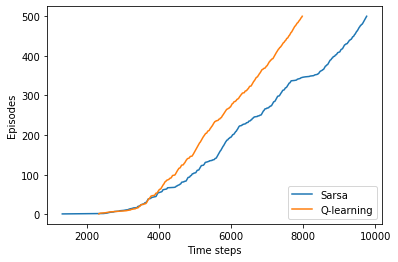

最佳决策Q-learning:
['←', '←', '↓', '←', '←', '←', '→', '↑', '→', '↓']
['↓', '↓', '↓', '↓', '←', '↓', '↑', '→', '↓', '↓']
['↓', '↓', '↓', '←', '↓', '↓', '↓', '↑', '↓', '↓']
['↓', '↓', '↓', '↓', '←', '↓', 'G↑', '→', '↓', '↓']
['↓', '↓', 'S↓', '←', '↓', '→', '↑', '←', '↓', '↓']
['←', '↓', '↓', '←', '→', '↑', '↑', '←', '↓', '↓']
['→', '→', '→', '→', '↑', '↑', '↑', '↑', '←', '←']
每一列风的强度:
['0', '0', '0', '1', '1', '1', '2', '2', '1', '0']
最佳决策Sarsa:
['↓', '→', '↑', '↑', '←', '→', '→', '→', '→', '↓']
['→', '→', '←', '←', '↑', '↑', '→', '→', '↓', '↓']
['↑', '↓', '↓', '←', '↓', '→', '↓', '→', '←', '↓']
['→', '→', '↓', '↓', '↓', '↓', 'G↑', '→', '←', '↓']
['→', '→', 'S↓', '←', '→', '→', '↑', '→', '←', '↓']
['→', '↓', '↓', '↑', '→', '↑', '↑', '←', '←', '↓']
['→', '→', '→', '→', '↑', '↑', '↑', '↑', '←', '←']
每一列风的强度:
['0', '0', '0', '1', '1', '1', '2', '2', '1', '0']


In [9]:
run()